In [1]:
import root_pandas as rp
import pandas as pd
import ROOT
from ROOT import TVector3, TRandom, TMath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Welcome to JupyROOT 6.18/00


In [2]:
# First Load the raw data

# The data is stored in 100 root files each containing 10k electron recoil simulations
# select number of files to read
num_files = 2

files_e = ['~/data/e_dir_fit/raw_data/he_co2_50keV_'+str(i)+'/he_co2_50keV_'+str(i)+'.root' for i in range(num_files) ]
    
df = rp.read_root(files_e)

df.columns

Index(['event_number', 'npoints', 'x', 'y', 'z', 't', 'q'], dtype='object')

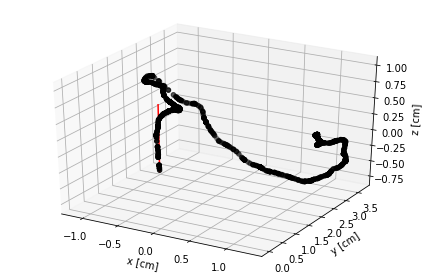

In [3]:
# Visualize a raw recoil simulation 

# Select recoil index
i = 12

# Obtain x, y, z info
x = df.iloc[i]['x']
y = df.iloc[i]['y']
z = df.iloc[i]['z']


# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c='k', marker='o')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
plt.tight_layout()

# Add red line for true direction (z direction)
ax.plot3D([0,0], [0,0], [0,1], c='r')

In [4]:
# Define tools to rotate track randomly

# This function rotates the track to a random direction
def rotate_track(track, to_dir):

    for charge in track:

        charge.RotateY(-(0.5*TMath.Pi()-to_dir.Theta()))
        charge.RotateZ(to_dir.Phi())


# This function draws an a 3-D vector from an isotropic distribution
def random_three_vector():

    """

    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution

    """

    phi = np.random.uniform()*2*np.pi

    costheta = 2.0*np.random.uniform()-1.0
    theta = TMath.ACos( costheta )

    x = TMath.Sin( theta) * TMath.Cos( phi )
    y = TMath.Sin( theta) * TMath.Sin( phi )
    z = TMath.Cos( theta )

    return TVector3(x,y,z)

In [5]:
# Total sigma_{x,y,z} [cm] used for diffusion
sigma = 466.0 * float(1e-4)

In [6]:
#  Draw random direction to rotate to
to_dir = random_three_vector()


In [7]:
# Transform the data and store in new list
x_new = []
y_new = []
z_new = []
    
    
for x,y,z in zip(df.iloc[i]['x'],df.iloc[i]['y'],df.iloc[i]['z']):
        
    # Create vector for each position
    charge = TVector3(x,y,z)
        
    # Rotate the Vector to to_dir
    charge.RotateY(to_dir.Theta())
    charge.RotateZ(to_dir.Phi())
        
    # Add diffusion
    charge += TVector3(sigma* np.random.normal(),sigma* np.random.normal(),sigma* np.random.normal())
        
    x_new += [charge[0]]
    y_new += [charge[1]]
    z_new += [charge[2]]

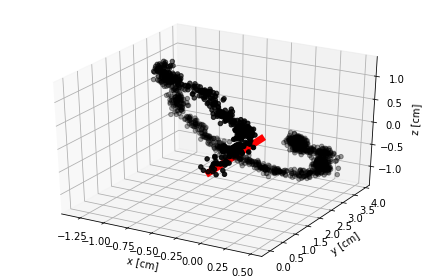

In [8]:
# Plot transformed simulation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_new, y_new, z_new, c='k', marker='o')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
plt.tight_layout()

# Add red line for true direction (z direction)
ax.plot3D([0,to_dir[0]], [0,to_dir[1]], [0,to_dir[2]], c='r',linewidth=7)

In [9]:
# Shift to data mean
x_final = []
y_final = []
z_final = []


mean_dir = TVector3(np.mean(x_new),np.mean(y_new),np.mean(z_new))

for x,y,z in zip(x_new,y_new,z_new):
    charge = TVector3(x,y,z)
    charge -= mean_dir    
    x_final += [charge[0]]
    y_final += [charge[1]]
    z_final += [charge[2]]

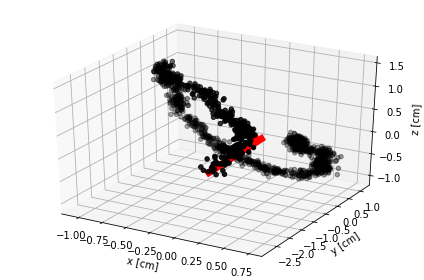

In [10]:
# Plot full recoil
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')




plt.tight_layout()
ax.scatter3D(x_final, y_final, z_final, c='k', marker='o')

# Show position of origin
ax.scatter3D([0], [0], [0], c='r', marker='o',s=50)


# Add red line for true direction 
dir_head = to_dir - mean_dir
dir_tail = -1.0*mean_dir
ax.plot3D([dir_tail[0],dir_head[0]], [dir_tail[1],dir_head[1]], [dir_tail[2],dir_head[2]], c='r',linewidth=7)